## **Imports**

In [0]:
# imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import sys
import math   
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import RFECV

In [0]:
import warnings
warnings.filterwarnings('ignore')

## Constants

In [0]:
#Activity label
activity_writing = 1
activity_pause = 0

In [0]:
#Sensor labels
sensor_a = 'Accelerometer Sensor'
sensor_la = 'Linear Acceleration Sensor'
sensor_g = 'Gyro Sensor'

In [0]:
#sensor constants
NUM_OF_SENSORS = 3
FREQUENCY = 50

In [0]:
ONE_KB_IN_BYTES = 1024

In [0]:
TRIM_ENDS = False

In [0]:
CREATE_WINDOW = False
WINDOW_SIZE = 10

### Experiment selector

In [0]:
#Select a number from 1 to 5
EXPERIMENT_NUMBER = 1

## **Linking notebook to drive**

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#uncomment when running after a gap
# !pip install bcolz

## Pre Processing

In [0]:
def preProcessWithoutWindows(df, activity):
  a_x = []
  a_y = []
  a_z = []
  g_x = []
  g_y = []
  g_z = []
  a_time = []
  g_time = []
  for row in df.iterrows():
      if(row[1]['sensor'] == 'Accelerometer Sensor'):
        a_x.append(row[1]['x'])
        a_y.append(row[1]['y'])
        a_z.append(row[1]['y'])
        a_time.append(row[1]['time'])

      if(row[1]['sensor'] == 'Gyro Sensor'):
        g_x.append(row[1]['x'])
        g_y.append(row[1]['y'])
        g_z.append(row[1]['y'])
        g_time.append(row[1]['time'])

  a_len = len(a_x)
  g_len = len(g_x)

  if(a_len > g_len):
    a_x = a_x[:g_len]
    a_y = a_y[:g_len]
    a_z = a_z[:g_len]
    a_time = a_time[:g_len]

  if(a_len < g_len):
    g_x = g_x[:a_len]
    g_y = g_y[:a_len]
    g_z = g_z[:a_len]
    g_time = g_time[:a_len]

  #avg time
  timestamp = [(x+y)/2 for x,y in zip(a_time, g_time)]
  
  df = pd.DataFrame({'time': timestamp, 'a_x': a_x,'a_y': a_y, 'a_z': a_z, 'g_x': g_x,'g_y': g_y, 'g_z': g_z})
  df['activity'] = activity
  df['time'] = pd.to_datetime(df['time'], unit='ms')
  print(df.columns)
  return df

In [0]:
def preProcessData(df, activity):
  
  #remove linear acceleration - senson not capturing correctly
  df = df[df.sensor != 'Linear Acceleration Sensor']

  #sort based on time
  df = df.sort_values(by=["time"])

  #trim ends
  if(TRIM_ENDS == True):
    df = trimEnds(df)
  
  if(CREATE_WINDOW == True):
    df = preProcessWithManualWindows(df, activity, WINDOW_SIZE)
  else:
    df = preProcessWithoutWindows(df, activity)
  print(df.head())
  return df

In [0]:
def preProcessWithWindows(df, activity, windowSize): #window size in ms
  
  #remove linear acceleration - senson not capturing correctly
  df = df[df.sensor != sen]
  
  #index by timestamp
  df = df.set_index(df.time)
  
  #extracting columns -- later change for different sensors
  df = df[['time','x','y','z']]
  
  #resample
  df = df.resample('10L')
  
  #creating windows
#   df['time'] = pd.to_datetime(df['time'], unit='ms')
#   df = df.groupby(Grouper(key='time', freq='L'))
  
  
  #remove linear acceleration - senson not capturing correctly
#   df = df[df.sensor != 'Linear Acceleration Sensor']
  
  #sort based on time
#   df = df.sort_values(by=["time"])
  
  return df
#   window_start = 
#   for data in df:
    

In [0]:
def createWindow(df):
  #setting timestamps for 10 ms window
  # new_time = time - (MOD(time,10))
  df['time'] = df['time'].apply(lambda x: (x - (x % WINDOW_SIZE)) )
  
  #convert to timestamp
  df['time'] = pd.to_datetime(df['time'], unit='ms')
  
  #groupby
  return df.groupby(['time']).mean()

In [0]:
def preProcessWithManualWindows(df, activity, windowSize): #window size in ms
  #remove linear acceleration - senson not capturing correctly
  df = df[df.sensor != sensor_la]
  
  #extract accelerometer
  df_a = df[df.sensor == sensor_a]
  
  #extract gyro
  df_g = df[df.sensor == sensor_g]
  
  df_a = createWindow(df_a)
  df_g = createWindow(df_g)
  
  df_a = df_a.rename(columns={'x': 'a_x', 'y': 'a_y', 'z': 'a_z'})
  df_g = df_g.rename(columns={'x': 'g_x', 'y': 'g_y', 'z': 'g_z'})
#   print(df_a.head())
  df = pd.merge(df_a, df_g, on='time')
#   df = df.rename(columns={'time': 'timestamp', 'a_x': 'acc_x'})
#   print(df.columns)
#   print (df.head())
  return df


In [0]:
def trimEnds(df):
  trim_values = FREQUENCY * NUM_OF_SENSORS
  print('old shape: ', df.shape)
  df = df.iloc[trim_values:]
  df = df.iloc[:-trim_values]
  print('new shape: ', df.shape)
  return df

## **Loading dataset**

### Writing data

In [0]:
user_1_writing_data = ['2019_04_15_16_58_31_notebook.csv','2019_04_09_08_01_38_nopause_notebook.csv','2019_04_12_16_40_15_nopause_notebook.csv','notebook_day4_nopause.csv']

user_2_writing_data = ['2019_04_12_22_33_09_user2_notebook.csv','2019_04_12_22_45_31_user2_notebook.csv','2019_04_12_22_51_18_user2_notebook.csv','2019_04_12_22_58_13_user2_notebook.csv','2019_04_12_23_27_03_user2_notebook.csv']

### Pause data

In [0]:
#pause data for data assumed to be same
user_1_pause_data = ['2019_04_13_01_32_24_pause.csv','2019_04_13_01_41_47_pause.csv','pause.csv']

### Aggregating data

In [0]:
#selecting data based on experiment
if (EXPERIMENT_NUMBER == 1):
  writing_data = user_1_writing_data
  pause_data = user_1_pause_data
elif (EXPERIMENT_NUMBER == 2):
  writing_data = user_1_writing_data
  pause_data = user_1_pause_data
  testing_data = user_2_writing_data
elif (EXPERIMENT_NUMBER == 3):
  writing_data = user_2_writing_data
  pause_data = user_1_pause_data
elif (EXPERIMENT_NUMBER == 4):
  writing_data = user_2_writing_data
  pause_data = user_1_pause_data
  testing_data = user_1_writing_data
elif (EXPERIMENT_NUMBER == 5):
  writing_data = user_1_writing_data + user_2_writing_data
  pause_data = user_1_pause_data
  

In [0]:
training_dataset_writing = writing_data
training_dataset_pause = pause_data
# testing_dataset = ['2019_04_12_23_27_03_user2_notebook.csv']
testing_real_scenario = ['2019_04_19_12_13_15_1min30sec.csv']

In [0]:
base_src = 'drive/My Drive/ProjectWork/Sem2/HAR/Dataset/renamed/'

## Load data for training and testing

In [0]:
df = pd.DataFrame()
df_writing = pd.DataFrame()
df_pause = pd.DataFrame()


In [98]:
for dataset in training_dataset_writing:
  data = pd.read_csv(base_src + 'notebook/no_pause/'+dataset, delimiter = ',')
  df_writing = pd.concat([df_writing,preProcessData(data, activity_writing)],keys=['x','y'],ignore_index=True)

Index(['time', 'a_x', 'a_y', 'a_z', 'g_x', 'g_y', 'g_z', 'activity'], dtype='object')
                        time       a_x       a_y       a_z  g_x  g_y  g_z  \
0 2019-04-15 11:28:31.247000 -0.040103  0.395941  0.395941  0.0  0.0  0.0   
1 2019-04-15 11:28:31.270500  2.346916  3.802890  3.802890  0.0  0.0  0.0   
2 2019-04-15 11:28:31.301000 -0.040103  0.395941  0.395941  0.0  0.0  0.0   
3 2019-04-15 11:28:31.310000  2.346916  3.802890  3.802890  0.0  0.0  0.0   
4 2019-04-15 11:28:31.327000 -0.040103  0.395941  0.395941  0.0  0.0  0.0   

   activity  
0         1  
1         1  
2         1  
3         1  
4         1  
Index(['time', 'a_x', 'a_y', 'a_z', 'g_x', 'g_y', 'g_z', 'activity'], dtype='object')
                        time       a_x       a_y       a_z       g_x  \
0 2019-04-09 02:31:38.212500 -0.818218  1.384746  1.384746 -0.001502   
1 2019-04-09 02:31:38.255000 -0.241216  3.889082  3.889082  0.016552   
2 2019-04-09 02:31:38.267500 -0.818218  1.384746  1.384746 -0.001

In [99]:
for dataset in training_dataset_pause:
  data = pd.read_csv(base_src + 'pause/'+dataset, delimiter = ',')
  df_pause = pd.concat([df_pause,preProcessData(data, activity_pause)],keys=['x','y'],ignore_index=True)

Index(['time', 'a_x', 'a_y', 'a_z', 'g_x', 'g_y', 'g_z', 'activity'], dtype='object')
                        time       a_x       a_y       a_z       g_x  \
0 2019-04-12 20:02:24.884000  0.201711  0.218770  0.218770 -0.282935   
1 2019-04-12 20:02:24.906500  0.256778  2.483685  2.483685 -0.500648   
2 2019-04-12 20:02:24.923500  0.201711  0.218770  0.218770 -0.282935   
3 2019-04-12 20:02:24.946500  0.256778  2.483685  2.483685 -0.500648   
4 2019-04-12 20:02:24.966500  0.201711  0.218770  0.218770 -0.282935   

        g_y       g_z  activity  
0  0.087245  0.087245         0  
1  0.138222  0.138222         0  
2  0.087245  0.087245         0  
3  0.138222  0.138222         0  
4  0.087245  0.087245         0  
Index(['time', 'a_x', 'a_y', 'a_z', 'g_x', 'g_y', 'g_z', 'activity'], dtype='object')
                        time       a_x       a_y       a_z       g_x  \
0 2019-04-12 20:11:47.571500 -2.628235 -7.344513 -7.344513 -0.014337   
1 2019-04-12 20:11:47.595000  0.249596 -2.19458

In [0]:
#concate writing and pause
df = pd.concat([df_writing, df_pause],keys=['x','y'],ignore_index=True)


In [0]:
df_test = pd.DataFrame()

In [102]:
for dataset in testing_real_scenario:
  data = pd.read_csv(base_src + 'Test/'+dataset, delimiter = ',')
  df_test = pd.concat([df_test,preProcessData(data, 3)],keys=['x','y'],ignore_index=True)

Index(['time', 'a_x', 'a_y', 'a_z', 'g_x', 'g_y', 'g_z', 'activity'], dtype='object')
                        time       a_x       a_y       a_z       g_x  \
0 2019-04-19 06:43:15.834500 -0.351349  1.542764  1.542764  0.197094   
1 2019-04-19 06:43:15.841500 -0.712874 -0.430058 -0.430058 -0.100269   
2 2019-04-19 06:43:15.861000 -0.351349  1.542764  1.542764  0.197094   
3 2019-04-19 06:43:15.886000 -0.712874 -0.430058 -0.430058 -0.100269   
4 2019-04-19 06:43:15.906500 -0.351349  1.542764  1.542764  0.197094   

        g_y       g_z  activity  
0 -0.130467 -0.130467         3  
1  0.038393  0.038393         3  
2 -0.130467 -0.130467         3  
3  0.038393  0.038393         3  
4 -0.130467 -0.130467         3  


In [0]:
if (EXPERIMENT_NUMBER == 2 or EXPERIMENT_NUMBER == 4):
  df_test = pd.DataFrame()
  for dataset in testing_data:
    data = pd.read_csv(base_src + 'notebook/no_pause/'+dataset, delimiter = ',')
    df_test = pd.concat([df_writing,preProcessData(data, activity_writing)],keys=['x','y'],ignore_index=True)

In [0]:
#shuffle -- here we don't need shuffling
#df = df.sample(frac=1).reset_index(drop=True)

## **Analysing Data**

In [104]:
df.head()

,a_x,a_y,a_z,activity,g_x,g_y,g_z,time
0,-0.040103,0.395941,0.395941,1.0,0.0,0.0,0.0,2019-04-15 11:28:31.247000
1,2.346916,3.802890,3.802890,1.0,0.0,0.0,0.0,2019-04-15 11:28:31.270500
2,-0.040103,0.395941,0.395941,1.0,0.0,0.0,0.0,2019-04-15 11:28:31.301000
3,2.346916,3.802890,3.802890,1.0,0.0,0.0,0.0,2019-04-15 11:28:31.310000
4,-0.040103,0.395941,0.395941,1.0,0.0,0.0,0.0,2019-04-15 11:28:31.327000


In [105]:
df.describe()

,a_x,a_y,a_z,activity,g_x,g_y,g_z
count,20713.000000,20713.000000,20713.000000,20713.000000,20713.000000,20713.000000,20713.000000
mean,-1.682127,-3.639131,-3.639131,0.512094,-0.022763,0.002349,0.002349
std,2.450725,3.537344,3.537344,0.499866,0.585605,0.228548,0.228548
min,-11.316793,-22.303486,-22.303486,0.000000,-9.589344,-4.445744,-4.445744
25%,-1.933916,-6.154595,-6.154595,0.000000,-0.090711,-0.027452,-0.027452
50%,-0.708085,-4.734833,-4.734833,1.000000,-0.003626,-0.001095,-0.001095
75%,-0.217274,-1.665467,-1.665467,1.000000,0.084521,0.027778,0.027778
max,11.303625,11.715727,11.715727,1.000000,7.219116,5.117995,5.117995


In [106]:
df_writing.shape

(10607, 8)

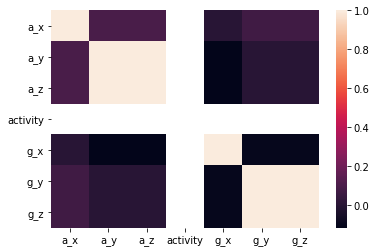

In [107]:
corr = df_writing.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

**Calculating hertz**

In [108]:
start_time = df_writing.iloc[0].time
samples=0
frequency= []
for data in df_writing['time']:
  samples = samples + 1
  if(pd.Timedelta(data - start_time).seconds >= 1):
    frequency.append(samples)
    samples = 0
    start_time = data
print(frequency)
print('frequency is ', np.mean(frequency), ' hertz')
from scipy import stats
print('frequency is ', stats.mode(frequency, axis=None), ' hertz')
  

[48, 50, 47, 27, 28, 26, 1, 26, 26, 1, 50, 50, 50, 50, 50, 27, 1, 51, 50, 25, 36, 26, 51, 49, 50, 50, 50, 50, 50, 50, 21, 12, 25, 1, 26, 1, 26, 26, 50, 50, 50, 25, 24, 16, 50, 50, 51, 21, 12, 2, 34, 43, 3, 50, 51, 48, 10, 1, 51, 2, 48, 51, 50, 50, 2, 11, 2, 49, 4, 1, 34, 17, 2, 24, 2, 42, 11, 25, 14, 15, 23, 1, 26, 26, 24, 16, 13, 1, 51, 51, 51, 50, 50, 50, 49, 1, 50, 50, 45, 24, 30, 2, 51, 51, 50, 35, 10, 3, 24, 3, 26, 25, 2, 50, 50, 37, 12, 3, 25, 24, 3, 24, 2, 23, 14, 51, 50, 28, 27, 3, 23, 4, 50, 50, 50, 24, 27, 27, 25, 21, 8, 8, 50, 50, 50, 10, 28, 6, 4, 50, 50, 50, 37, 12, 26, 3, 24, 3, 23, 4, 32, 20, 24, 3, 23, 3, 24, 23, 4, 2, 48, 5, 24, 3, 49, 50, 23, 4, 27, 23, 4, 27, 22, 4, 22, 4, 52, 25, 4, 4, 27, 23, 3, 24, 15, 50, 51, 51, 51, 50, 14, 13, 50, 50, 26, 10, 10, 50, 50, 50, 50, 14, 27, 5, 23, 2, 24, 15, 16, 51, 51, 39, 10, 2, 25, 2, 44, 6, 3, 24, 2, 51, 50, 42, 25, 28, 26, 40, 50, 48, 19, 10, 1, 52, 50, 51, 50, 32, 37, 2, 26, 51, 51, 51, 32, 11, 52, 51, 35, 1, 26, 1, 25, 19, 7

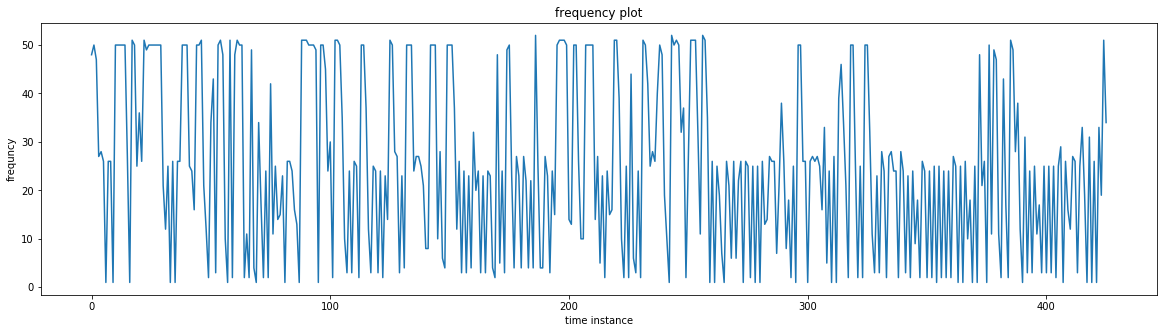

In [109]:
x = frequency
plt.figure(figsize=(20,5))
plt.plot(x) # plotting by columns

# naming the x axis 
plt.xlabel('time instance') 

# naming the y axis 
plt.ylabel('frequncy')
  
# giving a title to my graph 
plt.title('frequency plot') 
  
# function to show the plot 
plt.show()


In [0]:
range(1, len(frequency))

## Visualize data

In [0]:
# def plot_activity(activity, data):

#     fig, (ax0, ax1, ax2, ax3, ax4, ax5) = plt.subplots(nrows=6,
#          figsize=(15, 10),
#          sharex=True)
#     plot_axis(ax0, data['time'], data['a_x'], 'Accelerometer X-Axis')
#     plot_axis(ax1, data['time'], data['a_y'], 'Accelerometer Y-Axis')
#     plot_axis(ax2, data['time'], data['a_z'], 'Accelerometer Z-Axis')
#     plot_axis(ax3, data['time'], data['g_x'], 'Gyro X-Axis')
#     plot_axis(ax4, data['time'], data['g_y'], 'Gyro Y-Axis')
#     plot_axis(ax5, data['time'], data['g_z'], 'Gyro Z-Axis')
#     plt.subplots_adjust(hspace=0.2)
#     fig.suptitle(activity)
#     plt.subplots_adjust(top=0.90)
#     plt.show()

# def plot_axis(ax, x, y, title):

#     ax.plot(x, y, 'r')
#     ax.set_title(title)
#     ax.xaxis.set_visible(False)
#     ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
#     ax.set_xlim([min(x), max(x)])
#     ax.grid(True)



## Training plot

In [0]:
# for activity in np.unique(activity_writing):
#     subset = df_writing[df_writing['activity'] == activity][:180]
#     plot_activity(activity, subset)

In [0]:
# for activity in np.unique(activity_pause):
#     subset = df_pause[df_pause['activity'] == activity][:180]
#     plot_activity(activity, subset)

## Testing plot

In [0]:
# for activity in np.unique(3):
#     subset = df_test[df_test['activity'] == activity][:180]
#     plot_activity(activity, subset)

## **Class distribution**

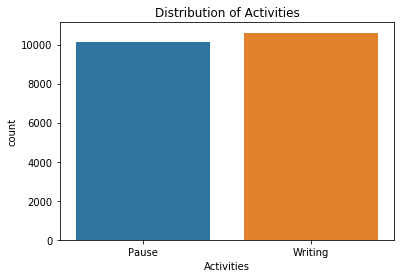

In [112]:


countPlot = sns.countplot(df['activity'],label="Sum")
plt.title('Distribution of Activities')
plt.xlabel('Activities')
plt.ylabel('count')

countPlot.set_xticklabels(['Pause', 'Writing'], fontsize=10)

plt.show()

## Extracting data for modelling

In [113]:
df_test.head()

,a_x,a_y,a_z,activity,g_x,g_y,g_z,time
0,-0.351349,1.542764,1.542764,3.0,0.197094,-0.130467,-0.130467,2019-04-19 06:43:15.834500
1,-0.712874,-0.430058,-0.430058,3.0,-0.100269,0.038393,0.038393,2019-04-19 06:43:15.841500
2,-0.351349,1.542764,1.542764,3.0,0.197094,-0.130467,-0.130467,2019-04-19 06:43:15.861000
3,-0.712874,-0.430058,-0.430058,3.0,-0.100269,0.038393,0.038393,2019-04-19 06:43:15.886000
4,-0.351349,1.542764,1.542764,3.0,0.197094,-0.130467,-0.130467,2019-04-19 06:43:15.906500


In [0]:
if (EXPERIMENT_NUMBER == 1 or EXPERIMENT_NUMBER == 3 or EXPERIMENT_NUMBER == 5):
  X = df[['a_x','a_y','a_z','g_x','g_y','g_z']]
  y = df['activity']
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.34)
else:
  X_train = df[['a_x','a_y','a_z','g_x','g_y','g_z']]
  y_train = df[['activity']]
  X_test = df_test[['a_x','a_y','a_z','g_x','g_y','g_z']]
  y_test = df_test[['activity']]
  print('test selected')

## **Classifiers**

In [0]:
#logistic regression
LR = LogisticRegression()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LR, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
LR_fit_time = scores['fit_time'].mean()
LR_score_time = scores['score_time'].mean()
LR_accuracy = scores['test_accuracy'].mean()
LR_precision = scores['test_precision_macro'].mean()
LR_recall = scores['test_recall_macro'].mean()
LR_f1 = scores['test_f1_weighted'].mean()
LR_roc = scores['test_roc_auc'].mean()
LR_model_size = math.ceil(sys.getsizeof(pickle.dumps(LR.fit(X_train, y_train))) / ONE_KB_IN_BYTES)

#Decision tree
decision_tree = DecisionTreeClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(decision_tree, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
dtree_fit_time = scores['fit_time'].mean()
dtree_score_time = scores['score_time'].mean()
dtree_accuracy = scores['test_accuracy'].mean()
dtree_precision = scores['test_precision_macro'].mean()
dtree_recall = scores['test_recall_macro'].mean()
dtree_f1 = scores['test_f1_weighted'].mean()
dtree_roc = scores['test_roc_auc'].mean()
dtree_model_size = math.ceil(sys.getsizeof(pickle.dumps(decision_tree.fit(X_train, y_train))) / ONE_KB_IN_BYTES)

#SVM
SVM = SVC(probability = True)

scoring = ['accuracy','precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(SVM, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
SVM_fit_time = scores['fit_time'].mean()
SVM_score_time = scores['score_time'].mean()
SVM_accuracy = scores['test_accuracy'].mean()
SVM_precision = scores['test_precision_macro'].mean()
SVM_recall = scores['test_recall_macro'].mean()
SVM_f1 = scores['test_f1_weighted'].mean()
SVM_roc = scores['test_roc_auc'].mean()
SVM_model_size = math.ceil(sys.getsizeof(pickle.dumps(SVM.fit(X_train, y_train))) / ONE_KB_IN_BYTES)

#Linear discriminant analysis
LDA = LinearDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(LDA, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
LDA_fit_time = scores['fit_time'].mean()
LDA_score_time = scores['score_time'].mean()
LDA_accuracy = scores['test_accuracy'].mean()
LDA_precision = scores['test_precision_macro'].mean()
LDA_recall = scores['test_recall_macro'].mean()
LDA_f1 = scores['test_f1_weighted'].mean()
LDA_roc = scores['test_roc_auc'].mean()
LDA_model_size = math.ceil(sys.getsizeof(pickle.dumps(LDA.fit(X_train, y_train))) / ONE_KB_IN_BYTES)

#Quadratic Discriminant Analysis
QDA = QuadraticDiscriminantAnalysis()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(QDA, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
QDA_fit_time = scores['fit_time'].mean()
QDA_score_time = scores['score_time'].mean()
QDA_accuracy = scores['test_accuracy'].mean()
QDA_precision = scores['test_precision_macro'].mean()
QDA_recall = scores['test_recall_macro'].mean()
QDA_f1 = scores['test_f1_weighted'].mean()
QDA_roc = scores['test_roc_auc'].mean()
QDA_model_size = math.ceil(sys.getsizeof(pickle.dumps(QDA.fit(X_train, y_train))) / ONE_KB_IN_BYTES)

#Random Forest
random_forest = RandomForestClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(random_forest, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
forest_fit_time = scores['fit_time'].mean()
forest_score_time = scores['score_time'].mean()
forest_accuracy = scores['test_accuracy'].mean()
forest_precision = scores['test_precision_macro'].mean()
forest_recall = scores['test_recall_macro'].mean()
forest_f1 = scores['test_f1_weighted'].mean()
forest_roc = scores['test_roc_auc'].mean()
forest_model_size = math.ceil(sys.getsizeof(pickle.dumps(random_forest.fit(X_train, y_train))) / ONE_KB_IN_BYTES)

#KNN
KNN = KNeighborsClassifier()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(KNN, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
KNN_fit_time = scores['fit_time'].mean()
KNN_score_time = scores['score_time'].mean()
KNN_accuracy = scores['test_accuracy'].mean()
KNN_precision = scores['test_precision_macro'].mean()
KNN_recall = scores['test_recall_macro'].mean()
KNN_f1 = scores['test_f1_weighted'].mean()
KNN_roc = scores['test_roc_auc'].mean()
KNN_model_size = math.ceil(sys.getsizeof(pickle.dumps(KNN.fit(X_train, y_train))) / ONE_KB_IN_BYTES)

#Bayes
bayes = GaussianNB()

scoring = ['accuracy', 'precision_macro', 'recall_macro' , 'f1_weighted', 'roc_auc']
scores = cross_validate(bayes, X_train, y_train, scoring=scoring, cv=20)

sorted(scores.keys())
bayes_fit_time = scores['fit_time'].mean()
bayes_score_time = scores['score_time'].mean()
bayes_accuracy = scores['test_accuracy'].mean()
bayes_precision = scores['test_precision_macro'].mean()
bayes_recall = scores['test_recall_macro'].mean()
bayes_f1 = scores['test_f1_weighted'].mean()
bayes_roc = scores['test_roc_auc'].mean()
bayes_model_size = math.ceil(sys.getsizeof(pickle.dumps(bayes.fit(X_train, y_train))) / ONE_KB_IN_BYTES)


## **Results**

In [116]:
models_initial = pd.DataFrame({
    'Model'       : ['Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes'],
    'Fitting time': [LR_fit_time, dtree_fit_time, SVM_fit_time, LDA_fit_time, QDA_fit_time, forest_fit_time, KNN_fit_time, bayes_fit_time],
    'Scoring time': [LR_score_time, dtree_score_time, SVM_score_time, LDA_score_time, QDA_score_time, forest_score_time, KNN_score_time, bayes_score_time],
    'Accuracy'    : [LR_accuracy, dtree_accuracy, SVM_accuracy, LDA_accuracy, QDA_accuracy, forest_accuracy, KNN_accuracy, bayes_accuracy],
    'Precision'   : [LR_precision, dtree_precision, SVM_precision, LDA_precision, QDA_precision, forest_precision, KNN_precision, bayes_precision],
    'Recall'      : [LR_recall, dtree_recall, SVM_recall, LDA_recall, QDA_recall, forest_recall, KNN_recall, bayes_recall],
    'F1_score'    : [LR_f1, dtree_f1, SVM_f1, LDA_f1, QDA_f1, forest_f1, KNN_f1, bayes_f1],
    'AUC_ROC'     : [LR_roc, dtree_roc, SVM_roc, LDA_roc, QDA_roc, forest_roc, KNN_roc, bayes_roc],
    'Size (KB)': [LR_model_size, dtree_model_size, SVM_model_size, LDA_model_size, QDA_model_size, forest_model_size, KNN_model_size, bayes_model_size],
    }, columns = ['Model', 'Fitting time', 'Scoring time', 'Accuracy', 'Precision', 'Recall', 'F1_score', 'AUC_ROC','Size (KB)'])

models_initial.sort_values(by='Accuracy', ascending=False)

,Model,Fitting time,Scoring time,Accuracy,Precision,Recall,F1_score,AUC_ROC,Size (KB)
5,Random Forest,0.214952,0.019196,0.968763,0.968821,0.968742,0.968762,0.991772,648
6,K-Nearest Neighbors,0.010343,0.107178,0.968253,0.968331,0.968238,0.968252,0.986801,1561
1,Decision Tree,0.086053,0.009532,0.956472,0.956491,0.956495,0.956473,0.956495,74
2,Support Vector Machine,8.852910,0.211406,0.943965,0.944514,0.943637,0.943937,0.977423,134
0,Logistic Regression,0.035692,0.009744,0.935258,0.935509,0.935085,0.935242,0.943075,1
7,Bayes,0.006410,0.009887,0.912800,0.915123,0.911928,0.912625,0.936145,1
3,Linear Discriminant Analysis,0.024975,0.011325,0.886537,0.895584,0.884645,0.885723,0.939718,2
4,Quadratic Discriminant Analysis,0.008496,0.012424,0.809525,0.836334,0.809635,0.801649,0.874474,2


## Model Plots

In [0]:
modelList = ('Logistic Regression', 'Decision Tree', 'Support Vector Machine', 'Linear Discriminant Analysis', 'Quadratic Discriminant Analysis', 'Random Forest', 'K-Nearest Neighbors', 'Bayes')


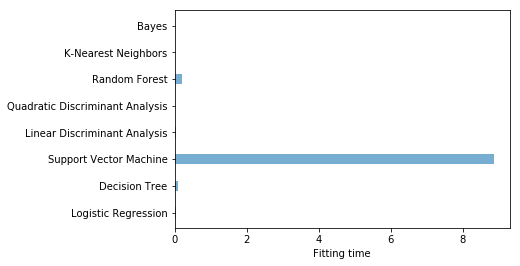

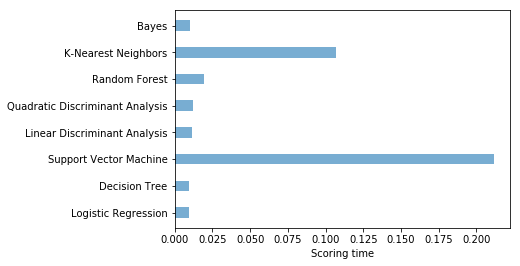

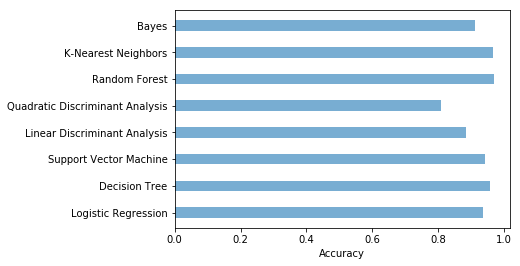

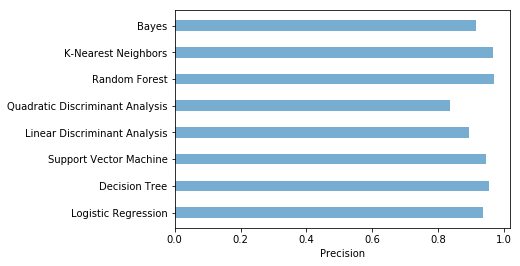

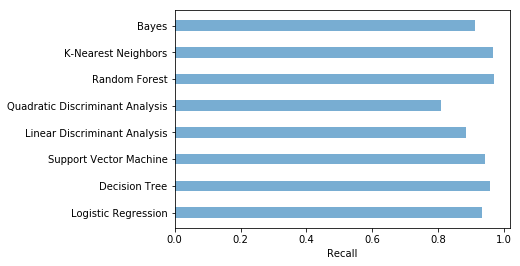

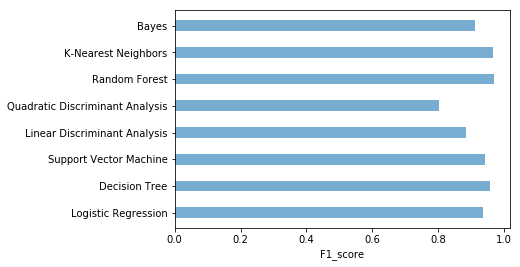

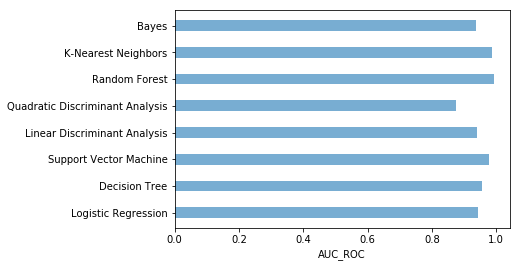

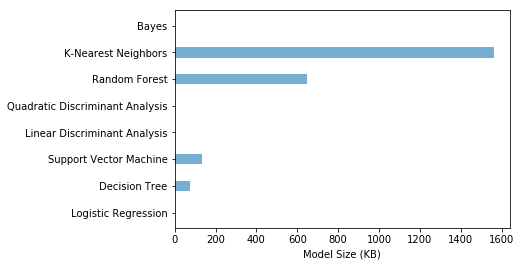

In [118]:
plt.xlabel('Fitting time')
performance = models_initial['Fitting time']
y_pos = np.arange(len(performance))
plt.barh(y_pos, performance, 0.4, align='center', alpha=0.6)
plt.yticks(y_pos, modelList)
plt.show()

plt.xlabel('Scoring time')
performance = models_initial['Scoring time']
y_pos = np.arange(len(performance))
plt.barh(y_pos, performance, 0.4, align='center', alpha=0.6)
plt.yticks(y_pos, modelList)
plt.show()

plt.xlabel('Accuracy')
performance = models_initial['Accuracy']
y_pos = np.arange(len(performance))
plt.barh(y_pos, performance, 0.4, align='center', alpha=0.6)
plt.yticks(y_pos, modelList)
plt.show()

plt.xlabel('Precision')
performance = models_initial['Precision']
y_pos = np.arange(len(performance))
plt.barh(y_pos, performance, 0.4, align='center', alpha=0.6)
plt.yticks(y_pos, modelList)
plt.show()

plt.xlabel('Recall')
performance = models_initial['Recall']
y_pos = np.arange(len(performance))
plt.barh(y_pos, performance, 0.4, align='center', alpha=0.6)
plt.yticks(y_pos, modelList)
plt.show()

plt.xlabel('F1_score')
performance = models_initial['F1_score']
y_pos = np.arange(len(performance))
plt.barh(y_pos, performance, 0.4, align='center', alpha=0.6)
plt.yticks(y_pos, modelList)
plt.show()

plt.xlabel('AUC_ROC')
performance = models_initial['AUC_ROC']
y_pos = np.arange(len(performance))
plt.barh(y_pos, performance, 0.4, align='center', alpha=0.6)
plt.yticks(y_pos, modelList)
plt.show()

plt.xlabel('Model Size (KB)')
performance = models_initial['Size (KB)']
y_pos = np.arange(len(performance))
plt.barh(y_pos, performance, 0.4, align='center', alpha=0.6)
plt.yticks(y_pos, modelList)
plt.show()

In [0]:
#Dummy to run till this point

## Saving model

In [0]:
import pickle 
  
random_forest.fit(X_train, y_train)
# Save the trained model as a pickle string. 
random_forest_saved_model = pickle.dumps(random_forest)

## Load saved model

In [0]:
# Load the pickled model 
random_forest_from_pickle = pickle.loads(random_forest_saved_model) 
  


## Testing saved model

In [0]:
X_test = df_test[['a_x','a_y','a_z','g_x','g_y','g_z']]

In [0]:
# Use the loaded pickled model to make predictions 
predicted_class = random_forest_from_pickle.predict(X_test)

In [0]:
print(len(X_test))
print(len(predicted_class))

391
391


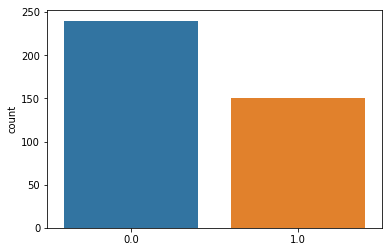

In [0]:

sns.countplot(predicted_class,label="Sum")

plt.show()

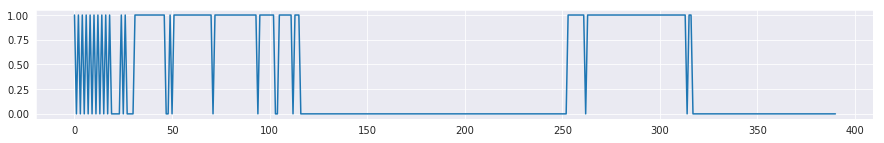

In [0]:
# sns.distplot(predicted_class, kde=False, rug=True);

sns.set_style("darkgrid")
plt.figure(figsize=(15,2))
plt.plot(predicted_class)
plt.show()

## **Previous work**

In [0]:
#Testing with 30-30 split and walking data

In [0]:
train = pd.read_csv('./dataset/notebook_day2.csv', delimiter = ',')
test = pd.read_csv('./dataset/walking_day1_3.csv', delimiter = ',') #test_data
# train = test = day2
#normalize train
# train = pd.DataFrame(preprocessing.normalize(train, norm='l2'))
cols_to_norm = ['x','y','z']
train[cols_to_norm] = train[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
test[cols_to_norm] = test[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
print(train)

## split the dataset
train = pd.DataFrame(np.random.randn(3188, 2))
msk = np.random.rand(len(train)) < 0.8
train = train[msk]
test = train[~msk]

# train = train.iloc[:, 0:len(train.columns) - 1]
# X_train, X_test, Y_train, Y_test = train_test_split(train, range(3986), test_size=0.33, random_state=42)
# train = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(train))

# X_train, Y_train = train.iloc[:, 0:len(train.columns) - 1], train.iloc[:, -1]
# X_test, Y_test = test.iloc[:, 0:len(test.columns) - 1], test.iloc[:, -1]

FileNotFoundError: ignored

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import accuracy_score # for evaluation

classifiers = [
    DecisionTreeClassifier(),
    #KNeighborsClassifier(7),
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(Y_pred, Y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

In [0]:
#Testing with no pause split and walking data

In [0]:
train = pd.read_csv('./dataset/notebook_day4_nopause.csv', delimiter = ',')
test = pd.read_csv('./dataset/walking_day1_3.csv', delimiter = ',') #test_data
X_train, Y_train = train.iloc[:, 0:len(train.columns) - 1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, 0:len(test.columns) - 1], test.iloc[:, -1]

In [0]:
classifiers = [
    DecisionTreeClassifier(),
    #KNeighborsClassifier(7),
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(Y_pred, Y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

In [0]:
#Testing with 30-30 split and eating data

In [0]:
train = pd.read_csv('./dataset/notebook_day2.csv', delimiter = ',')
test = pd.read_csv('./dataset/eating_day1.csv', delimiter = ',') #test_data
X_train, Y_train = train.iloc[:, 0:len(train.columns) - 1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, 0:len(test.columns) - 1], test.iloc[:, -1]

In [0]:
classifiers = [
    DecisionTreeClassifier(),
    #KNeighborsClassifier(7),
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(Y_pred, Y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

In [0]:
#Testing with no pause split and walking data

In [0]:
train = pd.read_csv('./dataset/notebook_day4_nopause.csv', delimiter = ',')
test = pd.read_csv('./dataset/eating_day1.csv', delimiter = ',') #test_data
X_train, Y_train = train.iloc[:, 0:len(train.columns) - 1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, 0:len(test.columns) - 1], test.iloc[:, -1]

In [0]:
classifiers = [
    DecisionTreeClassifier(),
    #KNeighborsClassifier(7),
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(Y_pred, Y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

In [0]:
#Testing with 30-30 split and writing data
train = pd.read_csv('./dataset/notebook_day2.csv', delimiter = ',')
test = pd.read_csv('./dataset/notebook_day3.csv', delimiter = ',') #test_data
X_train, Y_train = train.iloc[:, 0:len(train.columns) - 1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, 0:len(test.columns) - 1], test.iloc[:, -1]

classifiers = [
    DecisionTreeClassifier(),
    #KNeighborsClassifier(7),
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(Y_pred, Y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

In [0]:
#Testing with no pause and writing data
train = pd.read_csv('./dataset/notebook_day4_nopause.csv', delimiter = ',')
test = pd.read_csv('./dataset/notebook_day3.csv', delimiter = ',') #test_data
X_train, Y_train = train.iloc[:, 0:len(train.columns) - 1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, 0:len(test.columns) - 1], test.iloc[:, -1]

classifiers = [
    DecisionTreeClassifier(),
    #KNeighborsClassifier(7),
    SVC(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()
]

names = []
scores = []

for clf in classifiers:
    clf = clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    names.append(clf.__class__.__name__)
    scores.append(accuracy_score(Y_pred, Y_test))

score_df = pd.DataFrame({'Model': names, 'Score': scores}).set_index('Model')
score_df

## Idea Pad

In [0]:
from pandas import Grouper
df_writing = pd.DataFrame()
data = pd.DataFrame()
for dataset in training_dataset_writing:
  data = pd.read_csv(base_src + 'notebook/no_pause/'+dataset, delimiter = ',')
#   df_writing = pd.concat([df_writing,preProcessWithWindows(data, activity_writing, 0)],keys=['x','y'],ignore_index=True)
df_writing = preProcessWithWindows(data, activity_writing, 0)

In [0]:
df_writing.head()

In [0]:
print (pd.DataFrame(df_writing))


In [0]:
data.plot(alpha=0.5, style='-')
data.resample('L').mean().plot(style=':')